100%|██████████| 39999/39999 [00:16<00:00, 2483.21it/s]


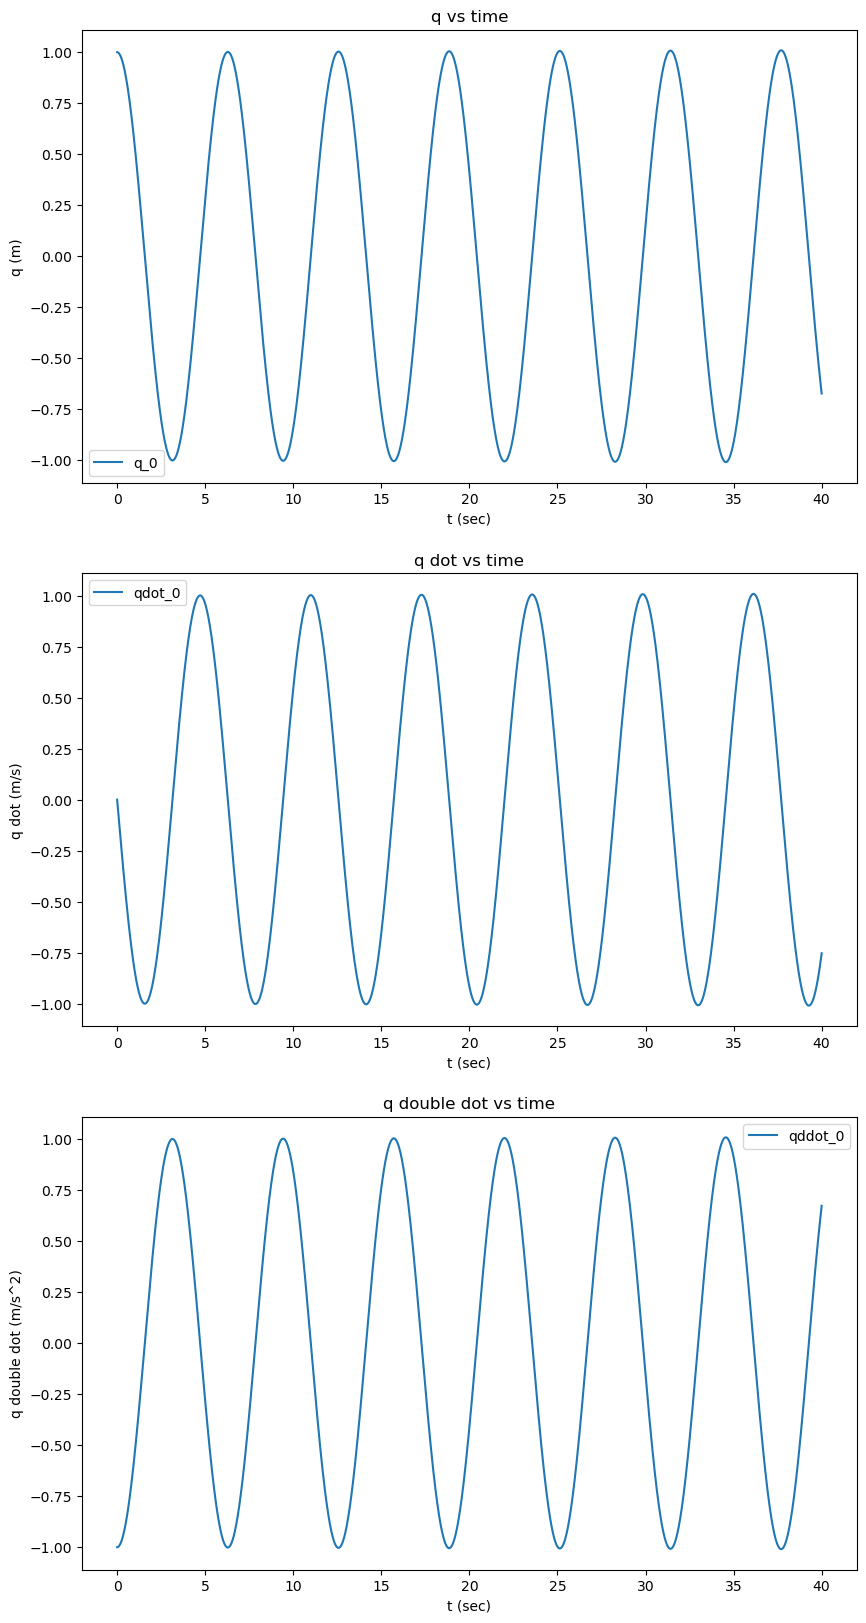

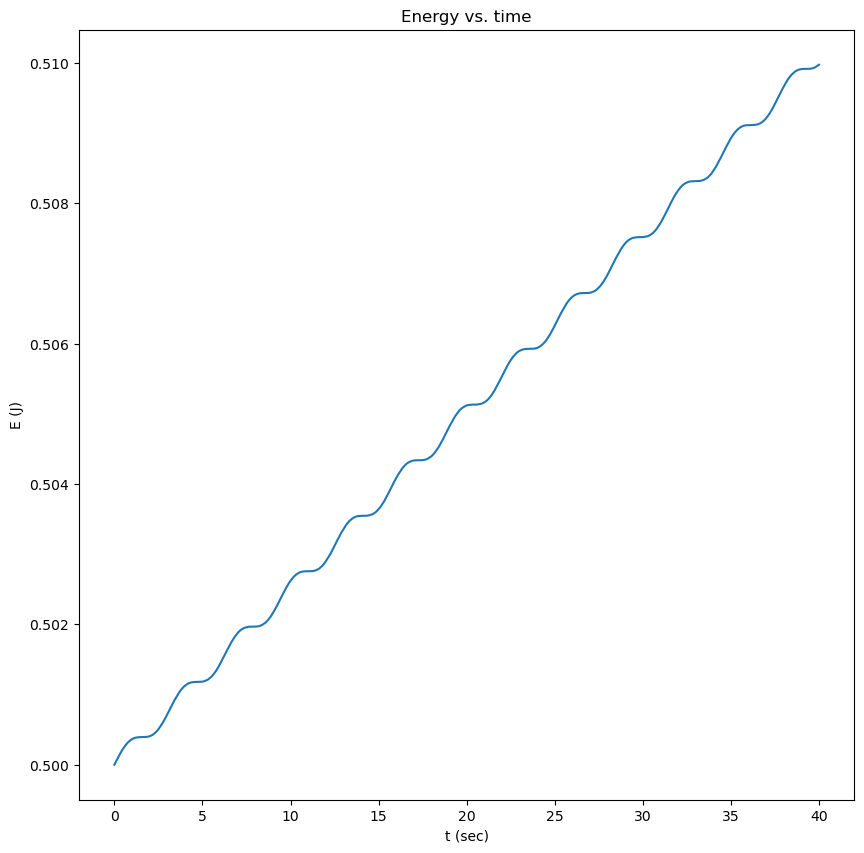

The mean energy is in this simulation is 5.05e-01
The range of energies in the simulation is 9.97e-03


In [178]:
#toy model of autograd Lagrangian mechanics 
import torch
from torch import tensor, autograd, sum, linalg, zeros, ones
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time


iterations = 40000
dt = 0.001

tmax = dt*iterations

d = 1

gpu = 0

#assign device
if gpu == 1:
    elif torch.cuda.is_available():
        dev = torch.device('cuda')
        datatype = torch.double
    else:
        dev = torch.device('cpu')
        datatype = torch.double
        print("CUDA device available! Data reported for CPU only!")
else:
    dev = torch.device('cpu')
    datatype = torch.double


if d == 1:
    k = tensor([1], requires_grad = False, dtype=datatype, device = dev)
    m = tensor([1], requires_grad = False, dtype=datatype, device = dev)
    
    q = tensor([1], requires_grad = True, dtype=datatype, device = dev)
    qdot = tensor([0], requires_grad = True, dtype=datatype, device = dev)
elif d == 2:
    k = tensor([1,4], requires_grad = False, dtype=datatype, device = dev)
    m = tensor([1], requires_grad = False, dtype=datatype, device = dev)
    
    q = tensor([1,0], requires_grad = True, dtype=datatype, device = dev)
    qdot = tensor([0,1], requires_grad = True, dtype=datatype, device = dev)


def L(vec):
    d = int(vec.size()[0]/2)
    qtemp = vec[:d]
    qdottemp = vec[d:]
    return (0.5*m*(qdottemp**2)).sum() - (0.5*k*(qtemp**2)).sum()

def qddot(q,qdot):
    v = torch.cat((q,qdot))
    d = int(v.size()[0]/2)
    full_hessian = autograd.functional.hessian(L,v)
    full_grad = autograd.functional.jacobian(L,v)
    grad_q = full_grad[:d]
    #grad_qdot = full_grad[d:] #not needed, but calculated anyways as part of the larger Jacobian call
    hess_q = full_hessian[:d,:d]
    hess_qdot = full_hessian[d:,d:]
    hess_q_qdot = full_hessian[d:,:d]

    return linalg.pinv(hess_qdot)@( grad_q - hess_q_qdot@qdot )



qdim = q.size()[0]
q_hist = zeros((qdim,iterations), device = dev)
qdot_hist = zeros((qdim,iterations), device = dev)
qddot_hist = zeros((qdim,iterations), device = dev)

q_hist[:,0] = q.data
qdot_hist[:,0] = qdot.data
qdd = qddot(q,qdot)
qdd = (0.5*qddot(q,qdot) + .5*qddot(q+dt*qdot, qdot + dt*qdd))/1
qddot_hist[:,0] = qdd

for i in tqdm.trange(1,iterations):
    q.data += dt*qdot.data
    qdot.data += dt*qdd
    qdd = (.5*qddot(q,qdot) + .5*qddot(q+dt*qdot, qdot + dt*qdd))/1
    q_hist[:,i] = q
    qdot_hist[:,i] = qdot
    qddot_hist[:,i] = qdd

#print(q_hist.data[0,:])
q_out = q_hist.cpu().data.detach().numpy()
qdot_out = qdot_hist.cpu().data.detach().numpy()
qddot_out = qddot_hist.cpu().data.detach().numpy()
#print(q_out)

fig, axs = plt.subplots(3,1,figsize = (10,20))
for i in range(qdim):
    axs[0].plot(np.linspace(0,tmax,iterations),q_out[i,:].T,label='q_'+str(i))
axs[0].legend()
axs[0].set_xlabel('t (sec)')
axs[0].set_ylabel('q (m)')
axs[0].set_title('q vs time')

for i in range(qdim):
    axs[1].plot(np.linspace(0,tmax,iterations),qdot_out[i,:].T,label='qdot_'+str(i))
axs[1].legend()
axs[1].set_xlabel('t (sec)')
axs[1].set_ylabel('q dot (m/s)')
axs[1].set_title('q dot vs time')

for i in range(qdim):
    axs[2].plot(np.linspace(0,tmax,iterations),qddot_out[i,:].T,label='qddot_'+str(i))
axs[2].legend()
axs[2].set_xlabel('t (sec)')
axs[2].set_ylabel('q double dot (m/s^2)')
axs[2].set_title('q double dot vs time')

plt.show()

fig, axs = plt.subplots(1,1,figsize = (10,10))
#check for energy conservation
E_hist = ((0.5*m*(qdot_out**2)).sum(axis=0) + (0.5*k*(q_out.T**2)).sum(axis=1)).cpu().detach().numpy()
axs.plot(np.linspace(0,tmax,iterations),E_hist )
axs.set_xlabel('t (sec)')
axs.set_ylabel('E (J)')
axs.set_title('Energy vs. time')


plt.show()
"""
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(q_out[0,:], q_out[1,:], q_out[2,:])
plt.show()
"""
print(f"The mean energy is in this simulation is {np.mean(E_hist):.2e}")
print(f"The range of energies in the simulation is {np.max(E_hist) - np.min(E_hist):.2e}")

Solving for exact solution parameters from initial conditions:

$E = \frac{1}{2}m\dot{q}^2 + \frac{1}{2}kq^2$

$E_{extremum} = \frac{1}{2}kA^2$, set $E = E_{extremum}$ such that

$A = \sqrt{ \frac{2}{k} E } = \sqrt{\frac{2}{k}\Big( \frac{1}{2}m\dot{q}^2 + \frac{1}{2}kq^2 \Big)} = \sqrt{\frac{1}{k}\Big( m\dot{q}^2 + kq^2 \Big)}$

For angular frequency:

$\omega = \sqrt{\frac{k}{m}}$

For phase:
$q(0) = A\cos(\omega 0 + \phi)$

Therefore $\phi = \cos^{-1}\big(\frac{q(0)}{A}\big)$


[1.]


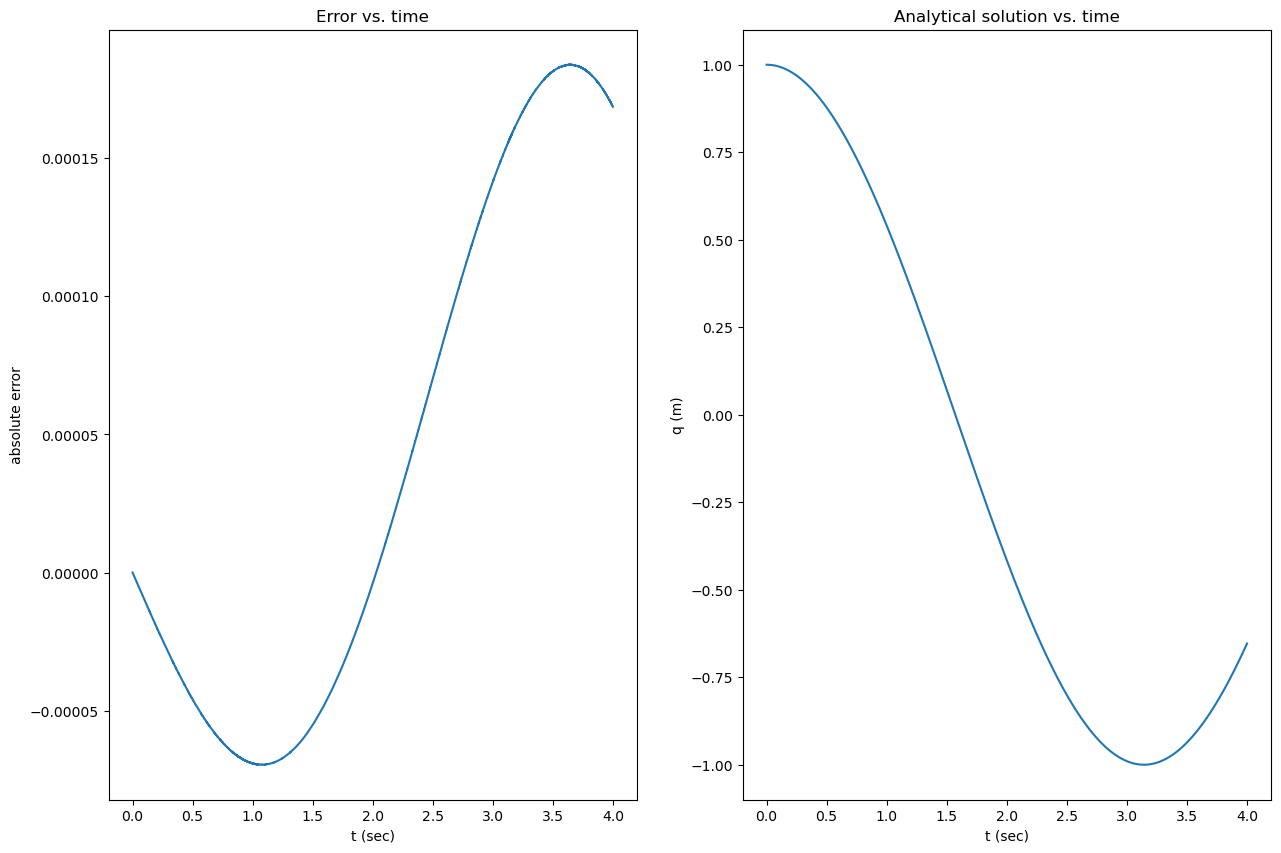

In [174]:
omega = np.sqrt(k.numpy()/m.numpy())
E = ((0.5*m*qdot_hist[:,0]**2).sum() + (0.5*k*q_hist[:,0]**2).sum()).detach().numpy()
A = (torch.sqrt((2/k)*E)).detach().numpy()
phi = np.arccos(q_out[:,0]/A)
tgrid = np.arange(0,tmax,dt)

print(A)
f = A*np.cos(omega*tgrid + phi)

fig, axs = plt.subplots(1,2,figsize=(15,10))

axs[0].plot(tgrid, (f-q_out[0,:].T))
#axs[0].plot(tgrid, (qdot_out*qddot_out).T/1000)
axs[0].set_xlabel('t (sec)')
axs[0].set_ylabel('absolute error')
axs[0].set_title('Error vs. time')

axs[1].plot(tgrid, f)
axs[1].set_xlabel('t (sec)')
axs[1].set_ylabel('q (m)')
axs[1].set_title('Analytical solution vs. time')

plt.show()



In [454]:
print(E)

tensor(0.5000, dtype=torch.float64, grad_fn=<AddBackward0>)


In [450]:
print(qdot_hist[:,0])

tensor([0.], grad_fn=<SelectBackward0>)
